# Rating predictions and recommendations

Any online shopping system in the last 10 years, probably have implemented recommendations. Some are like Amazon's, customers who bought X also bought Y, feature. These will be discussed in the Basket analysis section. Other recommendations are based on predicting the rating of a product, such as a movie.

The problem of learning recommendations based on past product ratings was made famous by the Netflix prize, a million-dollar machine-learning public challenge by Netflix. In this machine-learning problem, there is not only the information about which films the user saw, but also about how the user rated them.

In 2006, Netflix made a large number of customer ratings of films in its database available for a public challenge. In 2009, an international team named BellKor's Pragmatic Chaos was able to beat this mark and take the prize. They did so just 20 minutes before another team, the ensemble, passed the 10 percent mark as well—an exciting photo finish for a competition that lasted several years.

Machine learning in the real world: Much has been written about the Netflix Prize, and everyone may learn a lot by reading up on it. The techniques that won were a mixture of advanced machine learning and a lot of work put into preprocessing the data. For example, some users like to rate everything very highly, while others are always more negative; if this is not accounted in preprocessing, the model will suffer. Other normalizations were also necessary for a good result, bearing in mind factors such as the film's age and how many ratings it received. Good algorithms are a good thing, but it is always needed to get hands dirty and tune the methods to the properties of the data. Preprocessing and normalizing the data is often the most time-consuming part of the machine-learning process. However, this is also the place where one can have the biggest impact on the final performance of the system.

The first thing to note about the Netflix Prize is how hard it was. Roughly speaking, the internal system that Netflix used was about 10 percent better than having no recommendations at all (that is, assigning each movie just the average value for all users). The goal was to obtain just another 10 percent improvement on this. In total, the winning system was roughly just 20 percent better than no personalization. Yet it took a tremendous amount of time and effort to achieve this goal, and even though 20 percent does not seem like much, the result is a system that is useful in practice.

Unfortunately, for legal reasons, this dataset is no longer available. However, an academic dataset with similar characteristics can be used. This data comes from GroupLens, a research laboratory at the University of Minnesota.

How can a Netflix-style ratings prediction question be solved? Two different kinds of approach will be explored: neighborhood approaches and regression approaches. Also see how to combine these methods to obtain a single prediction.

# Splitting into training and testing

At a high level, splitting the dataset into training and testing data in order to obtain a principled estimate of the system's performance is performed in the same way that in previous chapters: a certain fraction of the data points is taken (10 percent will be used) and reserve them for testing; the rest will be used for training.

However, because the data is structured differently in this context, the code is different. In some of the models that have been explored, setting aside 10 percent of the users would not work as we transfer the data.

The first step is to load the data from the disk, for which the following function is used:

In [1]:
import requests, zipfile
from io import BytesIO
import numpy as np
from scipy import sparse

print('Downloading started')

#Defining the zip file URL
url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'

# Downloading the file by sending the request to the URL
req = requests.get(url)
print('Downloading Completed')

# extracting the zip file contents
zipfile= zipfile.ZipFile(BytesIO(req.content))
zipfile.extractall('./')

def load():
    data = np.loadtxt('./ml-100k/u.data')
    ij = data[:, :2]
    ij -= 1  # original data is in 1-based system
    values = data[:, 2]
    reviews = sparse.csc_matrix((values.astype(int), ij.T.astype(int))).astype(float)
    return reviews.toarray()

Note that zero entries in this matrix represent missing ratings:

In [2]:
reviews = load()
U, M = np.where(reviews)

The standard random module is now used to choose the indices to test:

In [3]:
import random

test_idxs = np.array(random.sample(range(len(U)), len(U)//10))

Now the train matrix is built, which is like reviews, but with the testing entries set to zero:

In [4]:
train = reviews.copy()
train[U[test_idxs], M[test_idxs]] = 0

Finally, the test matrix contains just the testing values:

In [5]:
test = np.zeros_like(reviews)
test[U[test_idxs], M[test_idxs]] = reviews[U[test_idxs], M[test_idxs]]

From now on, work on taking the training data, and try to predict all the missing entries in the dataset. That is, code that assigns each user–movie pair a recommendation will be written.

# Normalizing the training data

As it has been seen, it is best to normalize the data to remove obvious movie- or user-specific effects. One very simple type of normalization that was used before will be just used: conversion to z-scores.

Unfortunately, scikit-learn's normalization objects cannot be simply used as the missing values in the data have to be dealt with (that is, not all movies were rated by all users). Thus, the goal is to normalize by the mean and standard deviation of the values that are, in fact, present.

Custom class will be written so that it will ignore missing values. It can be even derived from scikit-learn's TransformerMixin class to add a fit_transform method. Next is to choose the axis of normalization. By default, it is normalized along the first axis, but sometimes it will be useful to normalize along the second one. This follows the convention of many other NumPy-related functions. The most important method is the fit method. In the implementation, the mean and standard deviation of the values that are not zero is computed. Recall that zeros indicate missing values. 0.1 is added to the direct estimate of the standard deviation to avoid underestimating the value of the standard deviation when there are only a few samples, all of which may be exactly the same. The exact value used does not matter much for the final result, but it is needed to avoid division by zero. The transform method needs to take care of maintaining the binary structure. Note how to took care of transposing the input matrix when the axis is 1 and then transformed it back so that the return value has the same shape as the input. The inverse_transform method performs the inverse operation to transform. Finally, the fit_transform method is added, which, as the name indicates, combines both the fit and transform operations:

In [6]:
from sklearn.base import TransformerMixin

class NormalizePositive(TransformerMixin):
    def __init__(self, axis=0):
        self.axis = axis
    
    def fit(self, features, y=None):
        if self.axis == 1:
            features = features.T
        # count features that are greater than zero in axis 0:
        binary = (features > 0)
        count0 = binary.sum(axis=0)
        # to avoid division by zero, set zero counts to one:
        count0[count0 == 0] = 1.
        # computing the mean is easy:
        self.mean = features.sum(axis=0)/count0
        # only consider differences where binary is True:
        diff = (features - self.mean) * binary
        diff **= 2
        # regularize the estimate of std by adding 0.1
        self.std = np.sqrt(0.1 + diff.sum(axis=0)/count0)
        return self
    
    def transform(self, features):
        if self.axis == 1:
            features = features.T
        binary = (features > 0)
        features = features - self.mean
        features /= self.std
        features *= binary
        if self.axis == 1:
            features = features.T
        return features

    def inverse_transform(self, features, copy=True):
        if copy:
            features = features.copy()
        if self.axis == 1:
            features = features.T
        features *= self.std
        features += self.mean
        if self.axis == 1:
            features = features.T
        return features

    def fit_transform(self, features):
        return self.fit(features).transform(features)

The methods that was defined (fit, transform, transform_inverse, and fit_transform) were the same as the objects defined in the sklearn.preprocessing module. In the following sections, the inputs will be first normalized, normalized predictions will be generated, and finally the inverse transformation will be applied to obtain the final predictions.

# A neighborhood approach to recommendations

The neighborhood concept can be implemented in two ways: user neighbors or movie neighbors. User neighbors will be only considered for the moment. At the end of this section, how the code can be adapted to compute movie neighbors will be discussed.

One of the interesting techniques that will be now explored is to just see which movies each user has rated, even without taking a look at what rating was given. In hindsight, this makes perfect sense—movies are not completely randomly chosen, but instead those are picked where an expectation of liking them is already obtained. Random choices of which movies to rate also are not made, but perhaps only those that feel most strongly about are rated (naturally, there are exceptions, but on average this is probably true).

The values of the matrix can be visualized as an image, where each rating is depicted as a little square. Black represents the absence of a rating and the gray levels represent the rating value.

The code to visualize the data is very simple (it can be adapted to show a larger fraction of the matrix than is possible to show in this book), as shown in the following code:

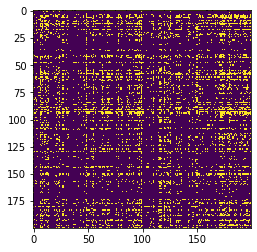

In [7]:
from matplotlib import pyplot as plt

# Build an instance of the object we defined previously
norm = NormalizePositive(axis=1)
binary = (train > 0)
train = norm.fit_transform(train)
# plot just 200x200 area for space reasons
fix, ax = plt.subplots()
ax.imshow(binary[:200, :200], interpolation='nearest')
plt.show()

It can be seen that the matrix is sparse—most of the squares are black. It can be also seen that some users rate a lot more movies than others, and that some movies receive many more ratings than others.

This binary matrix is now going to be used to make predictions of movie ratings. The general algorithm will be calculated (in pseudocode) as follows:
* For each user, rank every other user in terms of closeness. For this step, the binary matrix will be used and correlation is used as the measure of closeness (interpreting the binary matrix as zeros and ones allows to perform this computation).
* When it is needed to estimate a rating for a user—movie pair, look at all the users who have rated that movie and split them into two groups: the most similar half and the most dissimilar half. The average of the most similar half then is used as the prediction.

The scipy.spatial.distance.pdist function can be used to obtain the distance between all the users as a matrix. The code is as follows:

In [8]:
from scipy.spatial import distance

# compute all pair-wise distances:
dists = distance.pdist(binary, 'correlation')
# Convert to square form, so that dists[i,j]
# is distance between binary[i] and binary[j]:
dists = distance.squareform(dists)

This matrix can be used to select the nearest neighbors of each user. These neighbors are selected using the following code:

In [9]:
neighbors = dists.argsort(axis=1)

Now, iterate over all users to estimate predictions for all inputs:

In [10]:
# We are going to fill this matrix with results
filled = train.copy()
for u in range(filled.shape[0]):
    # n_u is neighbors of user
    n_u = neighbors[u, 1:]
    # t_u is training data
    for m in range(filled.shape[1]):
        # get relevant reviews in order!
        revs = train[n_u, m]
        # Only use valid entries:
        revs = revs[binary[n_u, m]]
        if len(revs):
            # n is the number of reviews for this movie
            n = len(revs)
            # consider half of the reviews plus one
            n //= 2
            n += 1
            revs = revs[:n]
            filled[u, m] = np.mean(revs)

The tricky part in the preceding snippet is indexing by the right values to select the neighbors who have rated the movie. Then, the half that is closest to the user is chosen (in the rev[:n] line) and those are averaged. Because some films have many reviews and others very few, it is hard to find a single number of users for all cases. Choosing half of the available data is a more generic approach than setting a fixed value.

To obtain the final result, the predictions need to be denormalized as follows:

In [11]:
predicted = norm.inverse_transform(filled)

The same metrics we learned about when discussing regression can be used. Recall that the r² score ranges from 0 (prediction is no better than baseline) to 1 (prediction is perfect). For convenience, it is often seen in percentage terms (from 0 to 100):

In [12]:
from sklearn import metrics

r2 = metrics.r2_score(test[test > 0], predicted[test > 0])
print('R2 score (binary neighbors): {:.1%}'.format(r2))

R2 score (binary neighbors): 30.2%


The preceding code computes the result for user neighbors. The same code can be used to compute the movie neighbors by transposing the input matrix. That is, now look for similar movies rated by the same user and average their ratings.

The recommendation code was wrapped in a function called predict_positive_nn, so it can be called with the transpose matrix and finally transpose the result:

In [13]:
def predict_positive_nn(otrain, necessary=None):
    binary = (otrain > 0)
    norm = NormalizePositive(axis=1)
    train = norm.fit_transform(otrain)
    
    # compute all pair-wise distances:
    dists = distance.pdist(binary, 'correlation')
    # Convert to square form, so that `dists[i,j]`
    # contains the distance between `binary[i]` and `binary[j]`:
    dists = distance.squareform(dists)

    neighbors = dists.argsort(axis=1)
    filled = train.copy()
    for u in range(filled.shape[0]):
        # n_u are the neighbors of user
        n_u = neighbors[u, 1:]
        for m in range(filled.shape[1]):
            if necessary is not None and not necessary[u, m]:
                continue
            # This code could be faster using numpy indexing trickery as the
            # cost of readibility (this is left as an exercise to the reader):
            revs = [train[neigh, m] for neigh in n_u if binary[neigh, m]]
            if len(revs):
                n = len(revs)
                n //= 2
                n += 1
                revs = revs[:n]
                filled[u,m] = np.mean(revs)
    # Finally, undo the normalization to get back the final reusl
    return norm.inverse_transform(filled)

train = reviews.copy()
train[U[test_idxs], M[test_idxs]] = 0

predicted = predict_positive_nn(train.T).T
r2 = metrics.r2_score(test[test > 0], predicted[test > 0])
print('R2 score (binary movie neighbors): {:.1%}'.format(r2))

R2 score (binary movie neighbors): 31.7%


It can be seen that the results are not that different.

# A regression approach to recommendations

An alternative to neighborhoods is to formulate recommendations as a regression problem and apply the methods that are learned in the Chapter 6.

First consider why this problem is not a good fit for a classification formulation. It could be certainly attempted to learn a five-class model, using one class for each possible movie rating. However, there are two problems with this approach:
* The different possible errors are not at all the same. For example, mistaking a 5-star movie for a 4-star one is not as serious a mistake as mistaking a 5-star movie for a 1-star on.
* Intermediate values make sense. Even if the inputs are only integer values, it is perfectly meaningful to say that the prediction is 4.3. We can see that this is a different prediction than 3.5, even if they both round to 4.

These two factors together mean that classification is not a good fit for the problem. The regression framework is a better fit.

For a basic approach, two choices again are available: movie-specific or user-specific models can be built. In this case, user-specific models are going to be first built. It is hypothesized that this will give a high value to users who are similar to another user (or a negative value to users who like the same movies that another user dislikes).

Setting up the train and test matrices is the same method as before (including running the normalization steps). Therefore, jump directly to the learning step:

1. First, a regression object is instantiated as follows (recall that, in Chapter 2, the conclusion had been reached that an elastic net with an automatic parameter search was a good general-purpose regression method):

In [14]:
from sklearn.linear_model import ElasticNetCV

reg = ElasticNetCV(alphas=[0.0125, 0.025, 0.05, .125, .25, .5, 1., 2., 4.])

2. A data matrix that will contain a rating for every user–movie pair then is built. It is initialized as a copy of the training data:

In [15]:
binary = (train > 0)
norm = NormalizePositive(axis=1)
train = norm.fit_transform(train)
filled = train.copy()

3. Now, iterate over all the users, and each time learn a regression model based only on the data that user has given:

In [16]:
for u in range(train.shape[0]):
    curtrain = np.delete(train, u, axis=0)
    # binary records whether this rating is present
    bu = binary[u]
    # fit the current user based on everybody else
    reg.fit(curtrain[:, bu].T, train[u, bu])
    # Fill in all the missing ratings
    filled[u, ~bu] = reg.predict(curtrain[:, ~bu].T)

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


4. Evaluating the method can be done exactly as before:

In [17]:
predicted = norm.inverse_transform(filled)
r2 = metrics.r2_score(test[test > 0], predicted[test > 0])
print('R2 score (user regression): {:.1%}'.format(r2))

R2 score (user regression): 27.8%


As before, this code can be adapted to perform movie regression by using the transposed matrix.

# Combining multiple methods

The aforementioned methods are now combined into a single prediction. Perhaps the first thought that comes to mind is that the predictions can be averaged. This might give decent results, but there is no reason to think that all estimated predictions should be treated the same. It might be that one is better than the others.

A weighted average can be tried, multiplying each prediction by a given weight before summing it all up. How are the best weights found, though? They are learnt from the data, of course!

Ensemble learning: A general technique in machine learning that is not just applicable in regression that are being used: ensemble learning. Different forms of ensemble learning differ in how the base predictors are combined.

In order to combine the methods, a technique called stacked learning will be used. Have a look at the following diagram:
# ![Stacked learning diagram](./Stacked%20learning%20diagram.PNG)

In order to fit this combination model, the training data will be splitted into two. Alternatively, cross-validation could has been used (the original stacked-learning model worked like this). However, in this case, there is enough data to obtain good estimates by leaving some aside.

Just as when hyperparameters were being fitted, two layers of training/testing splits are needed: a first higher-level split, and then inside the training split, a second split that can fit the stacked learner. This is analogous to how multiple levels of cross-validation are used when using an inner cross-validation loop to find hyperparameter values:

In [18]:
from sklearn import linear_model

def get_train_test(reviews):
    test_idxs = np.array(random.sample(range(len(U)), len(U)//10))

    train = reviews.copy()
    train[U[test_idxs], M[test_idxs]] = 0

    test = np.zeros_like(reviews)
    test[U[test_idxs], M[test_idxs]] = reviews[U[test_idxs], M[test_idxs]]
    return train, test

def predict_regression(otrain):
    binary = (otrain > 0)
    norm = NormalizePositive(axis=1)
    train = norm.fit_transform(otrain)

    reg = ElasticNetCV(alphas=[0.0125, 0.025, 0.05, .125, .25, .5, 1., 2., 4.])
    filled = train.copy()
    # iterate over all users:
    for u in range(train.shape[0]):
        curtrain = np.delete(train, u, axis=0)
        bu = binary[u]
        if np.sum(bu) > 10:
            reg.fit(curtrain[:,bu].T, train[u, bu])
            # Fill the values that were not there already
            filled[u, ~bu] = reg.predict(curtrain[:,~bu].T)
    return norm.inverse_transform(filled)

train = reviews.copy()
train[U[test_idxs], M[test_idxs]] = 0

# Now split the training again into two subgroups
tr_train, tr_test = get_train_test(train)
tr_predicted0 = predict_positive_nn(tr_train)
tr_predicted1 = predict_positive_nn(tr_train.T).T
tr_predicted2 = predict_regression(tr_train)
tr_predicted3 = predict_regression(tr_train.T).T
# Now assemble these predictions into a single array:
stack_tr = np.array([
    tr_predicted0[tr_test > 0],
    tr_predicted1[tr_test > 0],
    tr_predicted2[tr_test > 0],
    tr_predicted3[tr_test > 0],
]).T
# Fit a simple linear regression
lr = linear_model.LinearRegression()
lr.fit(stack_tr, tr_test[tr_test > 0])

c:\Users\robit\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


LinearRegression()

Now, the whole process is applied to the testing split and evaluate:

In [19]:
stack_te = np.array([
    tr_predicted0.ravel(),
    tr_predicted1.ravel(),
    tr_predicted2.ravel(),
    tr_predicted3.ravel(),
]).T
predicted = lr.predict(stack_te).reshape(train.shape)

Evaluation is as before:

In [20]:
r2 = metrics.r2_score(test[test > 0], predicted[test > 0])
print('R2 stacked: {:.2%}'.format(r2))

R2 stacked: 34.27%


The result of the stacked learning is better than any single method achieved. It is quite typical that combining methods is a simple way to obtain a small performance boost, but that the results are not earth shattering.

By having a flexible way to combine multiple methods, any idea that is wished can be simply tried by adding it into the mix of learners and letting the system fold it into the prediction. For example, the neighborhood criterion in the nearest-neighbor code can be replaced.

However, it does have to be careful to not overfit the dataset. In order to have a good estimate, and if data is plentiful, a portion of the data should be left untouched until a final model that is about to go into production is obtained. Then, testing the model on this held-out data will give an unbiased prediction of how well it should be expected to work in the real world.

Of course, collaborative filtering also works with neural networks, but don't forget to keep validation data available for the testing—or, more precisely, validating—the ensemble model.

# Basket analysis

The methods that have been looked at so far work well when there are numeric ratings of how much a user liked a product. This type of information is not always available, as it requires active behavior on the part of consumers.

Basket analysis is an alternative mode of learning recommendations. The following screenshot shows a snippet of Amazon.com's web page for Tolstoy's classic book War and Peace, demonstrating a common way to use these results:
# ![Amazon.com's web page](./Amazon.com's%20web%20page.PNG)

This mode of learning is, of course, not only applicable to shopping baskets. This depends on the business context, but keep in mind that the techniques are flexible and can be useful in many settings.

Beer and diapers: One of the stories that is often mentioned in the context of basket analysis is the diapers and beer story. There has been much discussion of whether this is true or just an urban myth. In this case, it seems that it is true. In the early 1990s, Osco Drug discovered that, in the early evening, beer and diapers were bought together, and it did surprise the managers who had, until then, never considered these two products to be similar. What is not true is that this led the store to move the beer display closer to the diaper section. Also, there is no idea whether it was really true that fathers were buying beer and diapers together more than mothers (or grandparents).

## Obtaining useful predictions

It is not just customers who bought X also bought Y, even though that is how many online retailers phrase their recommendations (see the Amazon.com screenshot given earlier); a real system cannot work like this. Because such a system would get fooled by very frequently bought items and would simply recommend that which is popular without any personalization.

For example, at a supermarket, many customers buy bread every time they shop, or almost every time (for the sake of argument, let say that 50 percent of visits end with the purchase of bread). So, if only focus on any particular item, say, dishwasher soap, and look at what is frequently bought with dishwasher soap, it might be found that bread is frequently bought with dishwasher soap. However, bread is frequently bought with anything else, just because people frequently buy bread.

The real goal is customers who bought X are statistically more likely to buy Y than the average customer who has not bought X. If customer buy dishwasher soap, customer is likely to buy bread, but not more so than the baseline. Similarly, a bookstore that simply recommended bestsellers no matter which books you had already bought would not be doing a good job of personalizing recommendations.

## Analyzing supermarket shopping baskets

As an example, look at dataset consisting of anonymous transactions at a supermarket in Belgium. The data file is available from several online sources.

Begin by loading the dataset and looking at some statistics (this is always a good idea):

In [276]:
from collections import defaultdict
from itertools import chain
# File is downloaded as a compressed file
import gzip

url = 'http://fimi.uantwerpen.be/data/retail.dat.gz'
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

# file format is a line per transaction
# of the form '12 34 342 5...'
dataset = [[int(tok) for tok in line.strip().split()] for line in gzip.open('retail.dat.gz')]
# It is more convenient to work with sets
dataset = [set(d) for d in dataset]
# count how often each product was purchased:
counts = defaultdict(int)
for elem in chain(*dataset):
    counts[elem] += 1

The resulting counts summarized can be seen in the following table:

In [277]:
countsv = np.array(list(counts.values()))
bins = [1, 2, 4, 8, 16, 32, 64, 128, 512]
print('{0:11} | {1:12}'.format('Number of times bought', 'Number of products'))
print('-------------------------------------------')
for i in range(len(bins)):
    bot = bins[i]
    top = (bins[i + 1] if (i + 1) < len(bins) else 100000000000)
    print('{0:16} - {1:3} | {2:12}'.format((bot if bot > 1 else ''), (top-1 if top < 1000 else ''), np.sum((countsv >= bot) & (countsv < top))))

Number of times bought | Number of products
-------------------------------------------
                 -   1 |         2224
               2 -   3 |         2438
               4 -   7 |         2508
               8 -  15 |         2251
              16 -  31 |         2182
              32 -  63 |         1940
              64 - 127 |         1523
             128 - 511 |         1225
             512 -     |          179


There are many products that have only been bought a few times. In order to be able to provide recommendations for these products, a lot more data would be needed.

There are a few open source implementations of basket analysis algorithms out there, but none that are well integrated with scikit-learn or any of the other packages that has been used. Therefore, one classic algorithm are going to be implemented. This algorithm is called the Apriori algorithm, and it is a bit old (it was published in 1994 by Rakesh Agrawal and Ramakrishnan Srikant), but it still works (algorithms, of course, never stop working; they just get superseded by better ideas).

The Apriori algorithm takes a collection of sets (that is, your shopping baskets) and returns sets that are very frequent as subsets (that is, items that together are part of many shopping baskets).

The algorithm works using a bottom-up approach: starting with the smallest candidates (those composed of a single element), it builds up, adding one element at a time. The algorithm takes a set of baskets and the minimum input that should be considered (a parameter that will be called minsupport). The first step is to consider all baskets with just one element with minimal support. Then, these are combined in all possible ways to build up two-element baskets. These are filtered in order to keep only those that have minimal support. Then, all possible three-element baskets are considered, those with minimal support are kept, and so on. The trick of Apriori is that when building a larger basket, it only needs to consider those that are built up of smaller sets.

The following diagram presents a schematic view of the algorithm:
# ![A schematic view of the Apriori algorithm](./A%20schematic%20view%20of%20the%20Apriori%20algorithm.PNG)

This algorithm shall be now implemented in code. The minimum support is need to be defined:

In [278]:
minsupport = 100

Support is the number of times a set of products was purchased together.

The goal of Apriori is to find item sets with high support. Logically, any item set with more than minimal support can only be composed of items that themselves have at least minimal support:

In [279]:
valid = set(k for k, v in counts.items() if (v >= minsupport))
dataset = [(valid&d) for d in dataset if len(valid&d)]

The initial itemsets are singletons (sets with a single element). In particular, all singletons that have at least minimal support are frequent itemsets:

In [280]:
itemsets = [frozenset([v]) for v in valid]

An index need to be set up to speed up computation using the following code:

In [281]:
baskets = defaultdict(set)
for i, ds in enumerate(dataset):
    for ell in ds:
        baskets[ell].add(i)

That is, baskets[i] contains the indices of all the elements in the dataset where i occurs. Now, the loop is given as follows:

In [290]:
# from tqdm import tqdm

# freqsets = []
# for i in range(16):
#     print(i)
#     nextsets = []
#     tested = set()
#     # Create a new candidate set by adding v to it
#     c_list = [(it | frozenset([v])) for it in itemsets for v in valid if v not in it]
#     for c in tqdm(c_list):
#         # check if we have tested it already
#         if c in tested:
#             continue
#         tested.add(c)
#         candidates = set()
#         for elem in c:
#             candidates.update(baskets[elem])
#         support_c = sum(1 for d in candidates if dataset[d].issuperset(c))
#         if support_c > minsupport:
#             nextsets.append(c)
#     freqsets.extend(nextsets)
#     itemsets = nextsets
#     if not len(itemsets):
#         break
# print("Finished!")

0


100%|██████████| 3446592/3446592 [04:05<00:00, 14020.89it/s] 


1


100%|██████████| 5108670/5108670 [6:57:28<00:00, 203.95it/s]    


2


100%|██████████| 2692008/2692008 [6:15:01<00:00, 119.64it/s]  


3


100%|██████████| 557753/557753 [1:35:07<00:00, 97.72it/s] 


4


100%|██████████| 50004/50004 [09:25<00:00, 88.49it/s] 

Finished!


In [291]:
# import pickle

# with open('./freqsets.pickle', 'wb') as f:
#     # Pickle the 'freqsets' dictionary using the highest protocol available.
#     pickle.dump(freqsets, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('./freqsets.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    freqsets = pickle.load(f)

The Apriori algorithm returns frequent itemsets—that is, baskets that are present above a certain threshold (given by the minsupport variable in the code).

# Association rule mining

Frequent item sets are not very useful by themselves. The next step is to build association rules. Because of this final goal, the whole field of basket analysis is sometimes called association rule mining.

An association rule is a statement of the type, if X, then Y—for example, if a customer bought War and Peace, then they will buy Anna Karenina. Note that the rule is not deterministic (not all customers who buy X will buy Y), but it is rather cumbersome to always spell it out: if a customer bought X, they are more likely than baseline to buy Y; thus, let say if X, then Y, but it is meant in a probabilistic sense.

Interestingly, both the antecedent and the conclusion may contain multiple objects: customers who bought X, Y, and Z also bought A, B, and C. Multiple antecedents may allow to make more specific predictions than are possible from a single item.

It is possible to get from a frequent set to a rule by just trying all the possible combinations of X implies Y.  However, the goal is to have valuable rules. Therefore, the value of a rule needs to be measured. A commonly used measure is called the lift. The lift is the ratio between the probability obtained by applying the rule and the baseline, as shown in the following formula:
# ![Lift formula](./Lift%20formula.PNG)

In the preceding formula, P(Y) is the fraction of all the transactions that include Y, while P(Y|X) is the fraction of transactions that include Y, given that they also include X. In practice, the goal is to have values of lift of at least 10, perhaps even 100.

Refer to the following code:

In [304]:
minlift = 5.0
nr_transactions = float(len(dataset))
for itemset in freqsets:
    for item in itemset:
        consequent = frozenset([item])
        antecedent = itemset - consequent
        base = 0.0
        # acount: antecedent count
        acount = 0.0
        # ccount : consequent count
        ccount = 0.0
        for d in dataset:
            if item in d:
                base += 1
            if d.issuperset(itemset):
                ccount += 1
            if d.issuperset(antecedent):
                acount += 1
        base /= nr_transactions
        p_y_given_x = ccount / acount
        lift = p_y_given_x / base
        if lift > minlift:
            print('Rule {0} -> {1} has consequent count: {2:.1f} ({3:.1f}%) antencedent count: {4} antencedent and concequent count: {5} lift: {6}'.format(antecedent, consequent, base*nr_transactions, base*100, acount, ccount, lift))

Rule frozenset({1046}) -> frozenset({32}) has consequent count: 15167.0 (17.6%) antencedent count: 365.0 antencedent and concequent count: 339.0 lift: 5.266851157569019
Rule frozenset({32}) -> frozenset({1046}) has consequent count: 365.0 (0.4%) antencedent count: 15167.0 antencedent and concequent count: 339.0 lift: 5.266851157569018
Rule frozenset({38}) -> frozenset({36}) has consequent count: 2936.0 (3.4%) antencedent count: 15596.0 antencedent and concequent count: 2790.0 lift: 5.240573589049942
Rule frozenset({36}) -> frozenset({38}) has consequent count: 15596.0 (18.1%) antencedent count: 2936.0 antencedent and concequent count: 2790.0 lift: 5.240573589049942
Rule frozenset({38}) -> frozenset({37}) has consequent count: 1074.0 (1.2%) antencedent count: 15596.0 antencedent and concequent count: 1046.0 lift: 5.371036144014389
Rule frozenset({37}) -> frozenset({38}) has consequent count: 15596.0 (18.1%) antencedent count: 1074.0 antencedent and concequent count: 1046.0 lift: 5.37103

Some of the results are shown in the following table. The counts are the number of transactions that include the consequent alone (that is, the base rate at which that product is bought), all the items in the antecedent, and all the items in the antecedent and the consequent:
| Antecedent         | Consequent | Consequent count   | Antecedent count | Antecedent and consequent count | Lift |
| ------------------ | ---------- | ------------------ | ---------------- | ------------------------------- | ---  |
| 48, 41, 270, 39    | 271        | 2094 (2.4 percent) | 258              | 104                             | 17   |
| 48, 41, 1,6011, 39 | 16010      | 1316 (1.5 percent) | 136              | 133                             | 64   |
| 48, 41, 1,6010, 39 | 16011      | 669 (0.8 percent)  | 261              | 133                             | 66   |

It can be seen, for example, that there were 258 transactions in which 48, 41, 270, and 139 were bought together. Of these, 104 also included 271, so the estimated conditional probability is 104/258 ≈ 40 percent. Compared to the fact that only 2.4 percent of all transactions included 271, this gives a lift of 17.

The need to have a decent number of transactions in these counts in order to be able to make relatively solid inferences is why frequent itemsets must be first selected. If rules were generated from an infrequent itemset, the counts would be very small; because of this, the relative values would be meaningless (or subject to very large error bars).

Note that there are many more association rules discovered from this dataset: the algorithm discovers 1030 rules (requiring support for the baskets of at least 100 and a minimum lift of 5). With datasets containing millions of transactions, many thousands of rules, even millions can be expected to be generated.

However, for each customer or product, only a few rules will be relevant at any given time. So each customer only receives a small number of recommendations.

## More advanced basket analysis

There are now other algorithms for basket analysis that run faster than Apriori. Note, though, that learning association rules can often be done offline, where efficiency is not as great a concern.

There are also methods that can be used to work with temporal information, leading to rules that take into account the order in which the purchases have been made. Consider, as an example, that someone buying supplies for a large party may come back for trash bags. It may make sense to propose trash bags on the first visit. However, it would not make sense to propose party supplies to everyone who buys a trash bag.